In [1]:
import osmnx as ox
import networkx as nx
import matplotlib.pyplot as plt
from matplotlib.colors import Normalize

import jax
import jax.numpy as jnp
import numpy as np

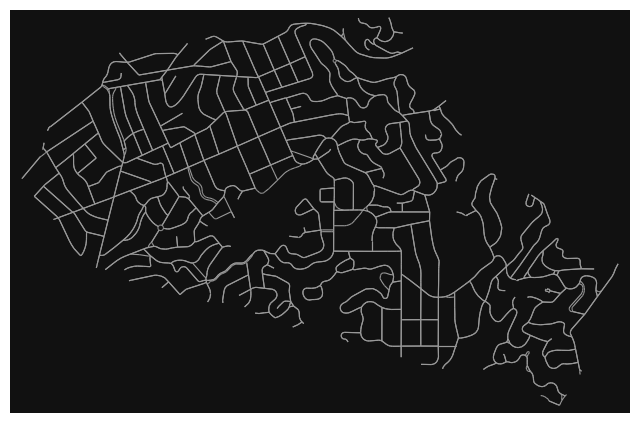

In [2]:
place_name = "Piedmont, California, USA"
G = ox.graph_from_place(place_name, network_type='drive', simplify=False)
fig, ax = ox.plot_graph(G, node_size=0, edge_linewidth=0.8)

In [3]:
V_0 = 50 # Desired speed (km/h)
T = 1.2/3600 # Time gap (h)
rho_max = 120 # Maximum density (veh/km)

l_eff = 1/rho_max # Inverse of the minimum distance headway
rho_C = 1/(V_0*T + l_eff) # Critical value between free traffic and congested traffic
C = 1/(T + l_eff/V_0)

@jax.jit
def Q_e(rho):
    return jnp.maximum(0, jnp.where(rho<=rho_C, V_0*rho, (1-rho*l_eff)/T))

In [4]:
T_sim = 1
N_t = 100
dt = T_sim/N_t

In [5]:
def init_graph():
    place_name = "Piedmont, California, USA"
    G = ox.graph_from_place(place_name, network_type='drive', simplify=False)

    for i,j, id in G.edges:
        rho = rho_max/4
        G.edges[i, j, id]['rho_old'] = rho
        G.edges[i, j, id]['Q_old'] = Q_e(rho)
        G.edges[i, j, id]['I'] = 1.

    return G

In [6]:
def plot_graph(G, ax, title=''):
    weights = [float(e[2]['rho_old']) for e in G.edges(data=True)]
    # Normalize the weights for colormap
    norm = plt.Normalize(min(weights), vmax=max(weights))
    #ax.set_title(title)
    cmap = plt.cm.viridis
    norm = Normalize(vmin=np.min(weights), vmax=np.max(weights))
    #nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin=20, edge_vmax=40) #, edge_vmin = min(weights), edge_vmax=max(weights))
    fig, ax = ox.plot_graph(G, edge_color=cmap(norm(weights)), node_size=0, edge_linewidth=0.8, bgcolor = 'white', show=False, ax=ax)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical')

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


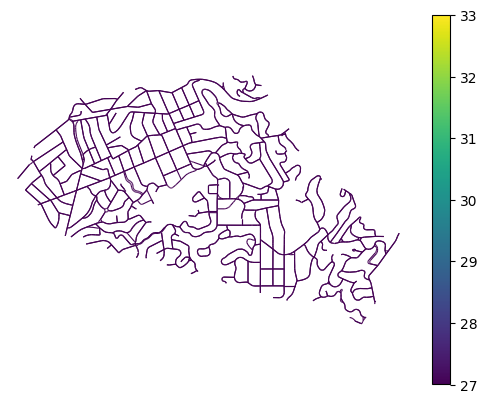

In [7]:
fig, ax = plt.subplots()
G = init_graph()
plot_graph(G, ax)

In [8]:
def CTM_step(G, verbose=False):
    for i, j, id in G.edges:
        rho_k = G.edges[i, j, id]['rho_old']
        Q_k = G.edges[i, j, id]['Q_old']
        I_k = G.edges[i, j, id]['I']

        edges_in_i = G.in_edges(i, data=True)
        edges_out_j = G.out_edges(j, data=True)

        edges_in_j = G.in_edges(j, data=True)
        edges_out_i = G.out_edges(i, data=True)

        if len(edges_in_i)==0:
            rho_k_m1 = -np.inf
            Q_k_m1 = np.inf
            D_k_m1 = np.where(rho_k_m1/I_k<=rho_C, Q_k_m1, C*I_k)
        else:
            D_k_m1 = 0
            for edge in edges_in_i:
                data_k_m1_i = edge[2]
                rho_k_m1_i = data_k_m1_i['rho_old']
                Q_k_m1_i = data_k_m1_i['Q_old']
                I_k_m1_i = data_k_m1_i['I']
                D_k_m1_i = np.where(rho_k_m1_i/I_k_m1_i<=rho_C, Q_k_m1_i, C*I_k_m1_i)
                D_k_m1 += D_k_m1_i

        # Divide flow between outgoing paths (TODO: difference between lanes, etc)
        D_k_m1 /= len(edges_out_i)

        if len(edges_out_j)==0:
            rho_k_p1 = np.inf
            Q_k_p1 = np.inf
            S_k_p1 = np.where(rho_k_p1/I_k>rho_C, Q_k_p1, C*I_k)
        else:
            S_k_p1 = 0
            for edge in edges_out_j:
                data_k_p1_i = edge[2]
                rho_k_p1_i = data_k_p1_i['rho_old']
                Q_k_p1_i = data_k_p1_i['Q_old']
                I_k_p1_i = data_k_p1_i['I']
                S_k_p1_i = np.where(rho_k_p1_i/I_k_p1_i>rho_C, Q_k_p1_i, C*I_k_p1_i)
                S_k_p1 += S_k_p1_i

        S_k_p1 /= len(edges_in_j)

        """ D_k = 0 # Review
        for edge in edges_in_j:
            data_k_i = edge[2]
            rho_k_i = data_k_i['rho_old']
            Q_k_i = data_k_i['Q_old']
            D_k_i = np.where(rho_k_i/I_k<=rho_C, Q_k_i, C*I_k)
            D_k += D_k_i """
        

        D_k = np.where(rho_k/I_k<=rho_C, Q_k, C*I_k)
        S_k = np.where(rho_k/I_k>rho_C, Q_k, C*I_k)
        Q_up = np.minimum(S_k, D_k_m1)
        Q_down = np.minimum(S_k_p1, D_k)

        if verbose:
            if i==-1 or i==4:
                print('#i', i)
                print('S_k', S_k)
                print('D_k', D_k)
                print('D_k_m1', D_k_m1)
                print('S_k_p1', S_k_p1)
                print('rho', rho_k)
                print('Q_up', Q_up)
                print('Q_down', Q_down)
                print(len(edges_in_j))
            
        rho_k = rho_k + dt/G.edges[i, j, id]['length']*(Q_up - Q_down)

        G.edges[i, j, id]['rho_new'] = rho_k
        G.edges[i, j, id]['Q_new'] = I_k*Q_e(rho_k/I_k)

    for e in G.edges:
        G.edges[e]['rho_old'] = G.edges[e]['rho_new']
        G.edges[e]['Q_old'] = G.edges[e]['Q_new']
    
    return G

[]

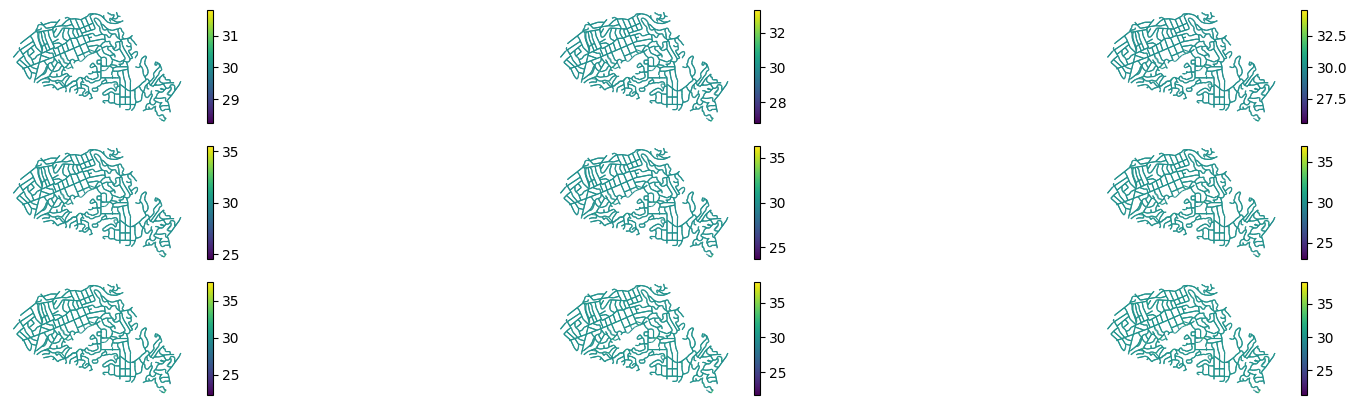

In [9]:
G = init_graph()

G_checkpoints = []
for t_i in range(10):
    G = CTM_step(G)
    if t_i%1 == 0:
        G_checkpoints += [G.copy()]

f, axs = plt.subplots(3, len(G_checkpoints)//3, figsize=(20,5))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], ax=ax, title=f'Step {i*200}')

plt.plot()

In [10]:
G = init_graph()

G_checkpoints = []
for t_i in range(N_t+1):
    G = CTM_step(G)
    if t_i%10 == 0:
        G_checkpoints += [G.copy()]

[]

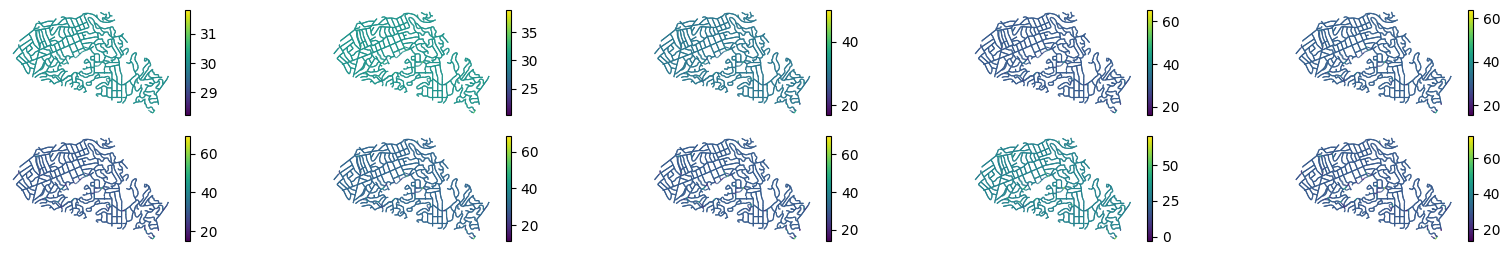

In [11]:
f, axs = plt.subplots(2, len(G_checkpoints)//2, figsize=(20,3))
for i, ax in enumerate(axs.reshape(-1)):
    plot_graph(G_checkpoints[i], ax=ax, title=f'Step {i*200}')

plt.plot()

In [71]:
def plot_graph2(G, ax=None, title=''):
    weights = [float(e[2]['rho_old']) for e in G.edges(data=True)]
    # Normalize the weights for colormap
    norm = plt.Normalize(min(weights), vmax=max(weights))
    #ax.set_title(title)
    cmap = plt.cm.plasma
    norm = Normalize(vmin=np.min(weights), vmax=np.max(weights))
    #nx.draw_networkx_edges(G, pos, node_size=0, arrowstyle='-', width=5, edge_color=weights, edge_cmap=cmap, ax=ax, edge_vmin=20, edge_vmax=40) #, edge_vmin = min(weights), edge_vmax=max(weights))
    fig, ax = ox.plot_graph(G, edge_color=cmap(norm(weights)), bgcolor='black', node_size=0, edge_linewidth=4, show=False)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = fig.colorbar(sm, ax=ax, orientation='vertical')
    return fig, ax

[]

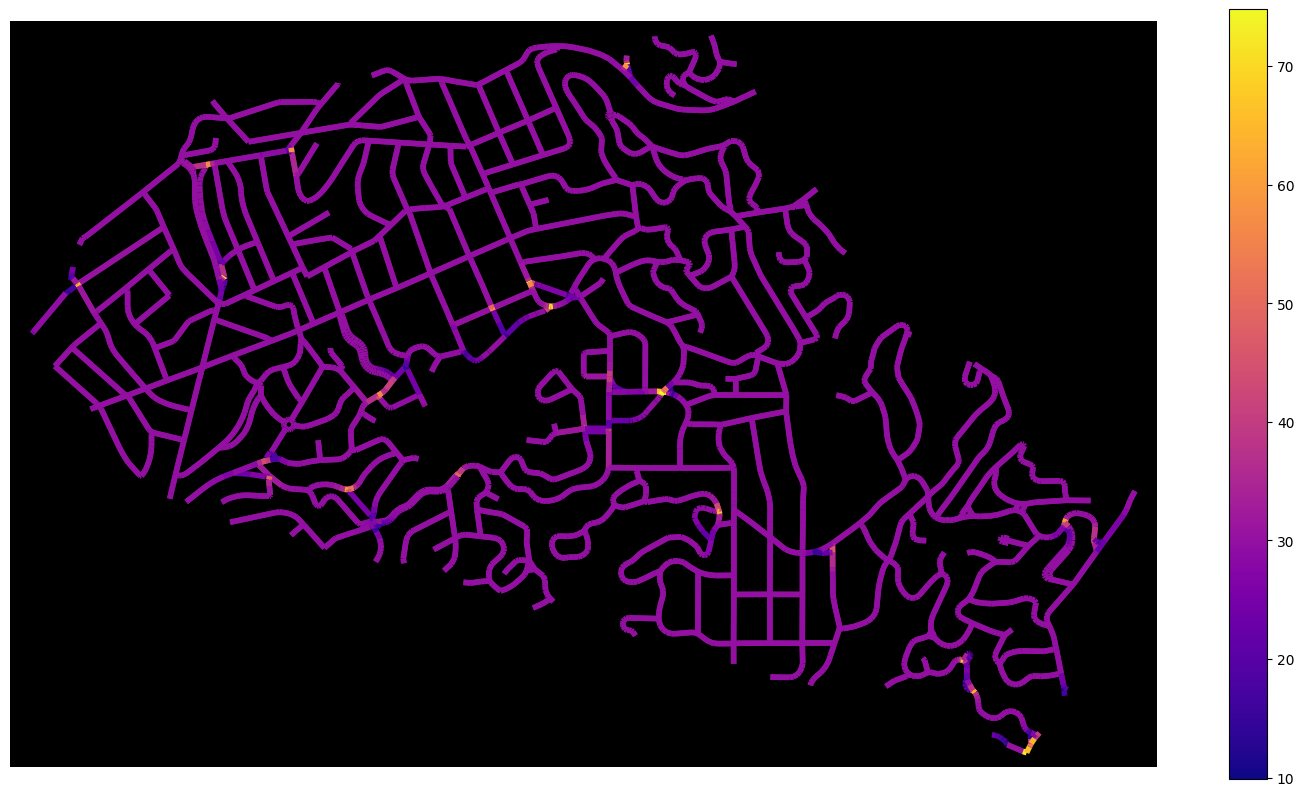

In [78]:
from matplotlib.pyplot import figure

#f, ax = plt.subplots(1, 1, figsize=(20,10))
#f.patch.set_facecolor('black')
fig, ax = plot_graph2(G_checkpoints[-1], ax=None, title=f'Step {i*200}')
#f.set_frameon(True)
fig.set_size_inches(18.5, 10.)
plt.plot()